In [1]:
## Importing Libraries ## 

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline
from scipy.optimize import minimize
import time

In [2]:
## This cell defines our Poission Process, Customer, and Customer List Classes ##

#############################
class PoissonProcess():
    def __init__(self, lam, T):
        self.lam = lam
        self.T = T
        self.simulate()

        
    def simulate(self, method='inter_arrival_time'):
        if method == 'inter_arrival_time':
            N = int(self.lam * self.T * 1.3)
            inter_ls = np.random.exponential(1/self.lam, size=N)
            arrival_time_ls = np.cumsum(inter_ls)
            self.arrival_time_ls = arrival_time_ls[arrival_time_ls <= self.T]
        if method == 'uniformity_property':
            N = np.random.poisson(self.T * self.lam)
            arrival_time_ls = np.random.uniform(0, self.T, size=N)
            self.arrival_time_ls = np.sort(arrival_time_ls)

            
    def get_arrival_time(self):
        return self.arrival_time_ls

    
    def print_parameter(self):
        print('lambda = {}, T = {}'.format(self.lam, self.T))

        
    def N_t(self, t):
        assert t >= 0
        assert t <= self.T
        if t == 0:
            return 0
        else:
            return np.argmax(self.arrival_time_ls > t)

        
    def plot_N_t(self, color='r',alpha=1):
        positive_inf = max(self.arrival_time_ls) * 1.2
        negative_inf = - max(self.arrival_time_ls) * 0.1
        n_arrival = len(self.arrival_time_ls)
        x_ls = np.concatenate([[negative_inf, 0], np.repeat(self.arrival_time_ls,2), [positive_inf]])
        y_ls = np.concatenate([[0], np.repeat(np.arange(n_arrival + 1),2)])
        plt.plot(x_ls, y_ls, c=color, alpha=alpha)        

#############################        
class Customer():
    def __init__(self, arrival_time=0, ctype='normal',wait_time=None):
        self.arrival_time = arrival_time
        self.ctype = ctype
        self.wait_time = wait_time
        
        
    def abandon_prob(self,prev_cust_wait):
        
        abandon_probs = {"<40":.005, ">=40<50":0.015, ">=50<60":0.03, ">=60<75":0.08, ">=75<90":0.1,
                         ">=90<105":0.1, ">=105<120":0.1, ">=120<180":0.1, ">=180":0.15,
                        }
        ### 170 is <<< 1800 so so our approximation the people in the line is okay
        if prev_cust_wait == 0:
            abandon_prob = 0
        elif prev_cust_wait<(40/60):
            abandon_prob = abandon_probs["<40"]
        elif prev_cust_wait>=(40/60) and prev_cust_wait<(50/60):
            abandon_prob = abandon_probs[">=40<50"]
        elif prev_cust_wait>=(50/60) and prev_cust_wait<(60/60):
            abandon_prob = abandon_probs[">=50<60"]
        elif prev_cust_wait>=(60/60) and prev_cust_wait<(75/60):
            abandon_prob = abandon_probs[">=60<75"]
        elif prev_cust_wait>=(75/60) and prev_cust_wait<(90/60):
            abandon_prob = abandon_probs[">=75<90"]
        elif prev_cust_wait>=(90/60) and prev_cust_wait<(105/60):
            abandon_prob = abandon_probs[">=90<105"]    
        elif prev_cust_wait>=(105/60) and prev_cust_wait<(120/60):
            abandon_prob = abandon_probs[">=105<120"]  
        elif prev_cust_wait>=(120/60) and prev_cust_wait<(180/60):
            abandon_prob = abandon_probs[">=120<180"]
        elif prev_cust_wait>=(180/60):
            abandon_prob = abandon_probs[">=180"]
            
        return abandon_prob
    
    
#############################
class Customer_ls():
    empty = ()

    def __init__(self, customer_ls=np.array([])):
        self.customer_ls = np.array(customer_ls)
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in customer_ls])]
        self.next = None if not customer_ls else self.customer_ls[0]

        
    def __len__(self):
        return len(self.customer_ls)
        
        
    def next_exits(self):
        if len(self)==1:
            next_cust, self.customer_ls = self.customer_ls[0], np.array([])
            self.next = None
        else:
            next_cust, self.customer_ls = self.customer_ls[0], self.customer_ls[1:]
            self.next = self.customer_ls[0]
        return next_cust
    
    
    def add_to_sort(self, customer):
        self.customer_ls = np.append(self.customer_ls, customer)
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in self.customer_ls])]
        self.next = self.customer_ls[0]
    
    
    def add_to_nosort(self, customer):
        self.customer_ls = np.append(self.customer_ls, customer)
        self.next = self.customer_ls[0]
    
    
    def sort(self):
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in self.customer_ls])]
        self.next = self.customer_ls[0]
        

#############################

In [3]:
## The cell contains a function to simulate a single day of the queueing system ##

def one_day_naive(arrival_ls):
    
    customer_arrivals = [Customer(arr) for arr in arrival_ls]
    customer_arrivals = Customer_ls(customer_arrivals)
    NormalQueue, cust_output = Customer_ls(), Customer_ls()
    
    switched_11, switched_1 = False, False
    capacity_8, capacity_11, capacity_1 = 136, 170, 204
    train_capacity = capacity_8
    
    train_finish_time, prev_wait_time = 0, 0
    while len(customer_arrivals) > 0 or len(NormalQueue) > 0:
        
        next_arr = customer_arrivals.next
        
        ## FIRST CAR DOESN"T LEAVE TILL FULL ##
        if train_finish_time == 0 and len(NormalQueue)<train_capacity:
            next_arrival = customer_arrivals.next_exits()
            NormalQueue.add_to_nosort(next_arrival)
            if len(NormalQueue)==train_capacity:
                train_finish_time = NormalQueue.customer_ls[-1].arrival_time
        
        ## ARRIVAL TO SYSTEM ##
        elif len(customer_arrivals)>0 and (len(NormalQueue)==0 or next_arr.arrival_time<train_finish_time):
            next_arrival = customer_arrivals.next_exits()
            NormalQueue.add_to_nosort(next_arrival)
        
        ## SEND A TRAIN ##
        else:
            if train_finish_time > 3 and not switched_11: 
                train_capacity = capacity_11
                switched_11 = True
            elif train_finish_time > 5 and not switched_1:
                train_capacity = capacity_1
                switched_1 = True
                
            load_min, load_max = 0.5/60, 1./60
            unload_min, unload_max = 0.25/60, 0.75/60
            
            load_time = np.random.uniform(load_min, load_max)
            unload_time = np.random.uniform(unload_min, unload_max)
            service_time = load_time + 3./60 + unload_time
 
            train_max = min(train_capacity,len(NormalQueue))
            train_count = 0
            while train_count < train_max:
                
                ## PROCESS THE NEXT CUSTOMER FROM NormalQueue ##
                if len(NormalQueue)!=0:
                    next_served = NormalQueue.next_exits()
                    abandon_prob = next_served.abandon_prob(prev_wait_time)
                    
                    ## NO ABANDON ##
                    if np.random.binomial(n=1,p=1-abandon_prob):
                        new_wait_time = max(0,train_finish_time-next_served.arrival_time)
                        next_served.wait_time = new_wait_time
                        cust_output.add_to_nosort(next_served)
                        prev_wait_time = new_wait_time
                        train_count += 1
                    
                    ## ABANDON ##
                    else:
                        next_served.wait_time = -999
                        cust_output.add_to_nosort(next_served)
                
                ## EXIT IF BOTH QUEUES ARE EMPTY ##
                elif len(NormalQueue) == 0:
                    train_max = train_count
                    
            train_finish_time = train_finish_time + service_time

    return cust_output

In [4]:
## This cell simulates 30 days of our queuing system, and outputs the day, arrival times, and wait times ## 

arrival_rate_param = 2880

## Simulating Trials ##
trials = 31
df = pd.DataFrame()
for i in np.arange(1, trials): 
    
    ## Simulating Arrivals ##
    process = PoissonProcess(lam = arrival_rate_param, T = 12.00)
    arrival_ls = process.get_arrival_time()
    customers = one_day_naive(arrival_ls).customer_ls
    
    ## Creating Data Frame ##
    data = {
        'day' : i*np.ones(len(arrival_ls)).astype(int),
        'arrival' : [customer.arrival_time for customer in customers], 
        'wait' : [60*customer.wait_time for customer in customers]}
    df = df.append(pd.DataFrame(data))

## Cleaning the Data Frame ##
df['arrival hour'] = df['arrival'].astype(str).str.split('.').apply(lambda x: x[0]).astype(int)
abandoned_df = df[df['wait'] < 0]
df = df[df['wait'] >= 0]
df.head(5)

,day,arrival,wait,arrival hour
0,1,0.000080,2.625618,7
1,1,0.000333,2.610411,0
2,1,0.001225,2.556926,0
3,1,0.001355,2.549111,0
4,1,0.001633,2.532429,0


In [18]:
## Creating Output Data Frame ## 

day_grouped = df.groupby('day').count()['arrival']
hr_grouped = df.groupby('arrival hour').count()['arrival']/(trials-1)
abandon_percents = 100* (abandoned_df.groupby('day').size() / df.groupby('day').size())

stats = [np.min, np.mean, np.max]
one = [np.round(stat(df['wait']), 3) for stat in stats]
two = [np.floor(stat(hr_grouped)) for stat in stats]
three = [np.floor(stat(day_grouped)) for stat in stats]
four = [np.round(stat(abandon_percents), 2) for stat in stats]
data = {'' :['Wait Time', '', '', 'Hourly Throughput', '', '', 'Daily Throughput', '', '', 
             'Abandonment Percentage', '', ''],
        'Statistic' : ['Minimum', 'Average', 'Maximum']*4, 
        'Value' : np.append(one, [two, three, four])}
out = pd.DataFrame(data).set_index('')
out

,Statistic,Value
,,
Wait Time,Minimum,0.000
,Average,53.638
,Maximum,78.562
Hourly Throughput,Minimum,2634.000
,Average,2755.000
,Maximum,2863.000
Daily Throughput,Minimum,32739.000
,Average,33063.000
,Maximum,33370.000


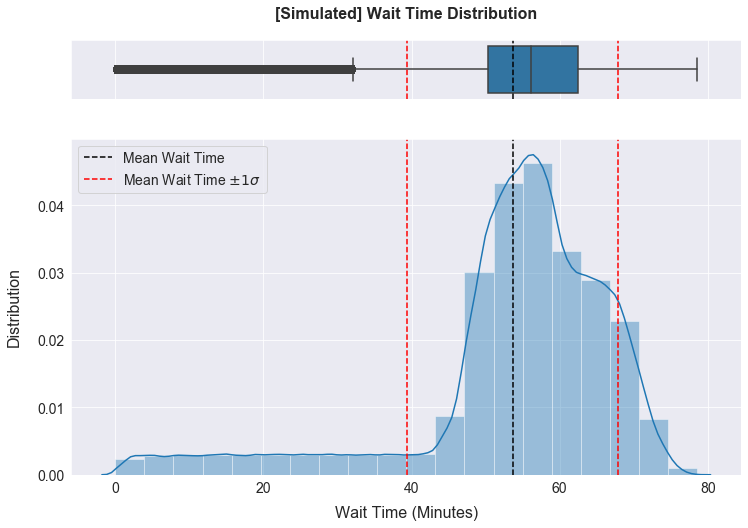

In [24]:
## Plotting Wait Time Distribution ## 

sns.set_style('darkgrid')
fig1a, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (12,8))
plt.title('[Simulated] Wait Time Distribution', fontsize = 16, pad = 120, fontweight = 'semibold')

avg = df['wait'].mean()
std = df['wait'].std()

sns.distplot(df['wait'], hist = True, bins = 20, kde = True, ax = ax_hist)
sns.boxplot(df['wait'], ax = ax_box)
ax_hist.axvline(avg, c = 'k', linestyle = 'dashed', label = 'Mean Wait Time')
ax_hist.axvline(avg + std, c = 'r', linestyle = 'dashed', label = 'Mean Wait Time $ \pm 1 \sigma$')
ax_hist.axvline(avg - std, c = 'r', linestyle = 'dashed')

ax_box.axvline(avg,       c = 'k', linestyle = 'dashed')
ax_box.axvline(avg + std, c = 'r', linestyle = 'dashed')
ax_box.axvline(avg - std, c = 'r', linestyle = 'dashed')

ax_box.set(xlabel='')

plt.xlabel('Wait Time (Minutes)', fontsize = 16, labelpad = 10)
plt.ylabel('Distribution', fontsize = 16, labelpad = 15)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(prop={'size': 14})
fig1a.savefig('fig1a.pdf')

In [12]:
## All the posted wait time stuff so I can plot it ## 
olddf = pd.read_csv('Posted_Wait_Times.csv')
olddf['dt'] = pd.to_datetime(olddf['datetime'])
olddf.drop(['date', 'datetime', 'SACTMIN'], axis = 1, inplace = True)
olddf['date'] = olddf['dt'].dt.date
olddf['time'] = olddf['dt'].dt.time
olddf['hour'] = olddf['dt'].dt.hour
olddf['month'] = olddf['dt'].dt.month
olddf.drop(['date'], axis = 1, inplace = True)
olddf.rename(columns = {'SPOSTMIN': 'wait'}, inplace = True)
olddf.dropna(inplace = True)
olddf = olddf[olddf['wait'] > 0]
olddf = olddf[['dt', 'month', 'hour', 'time', 'wait']]

# Creating Data Frame for November ##
november = olddf[(olddf['month'] == 11) & (olddf['hour'] >= 8) & (olddf['hour'] <= 20)].reset_index().drop('index', axis = 1)
november.head(5)

november_grouped = november.groupby('hour').mean()
november_grouped = november_grouped.drop('month', axis = 1).reset_index()

In [8]:
november_grouped = november_grouped.drop('month', axis = 1).reset_index()

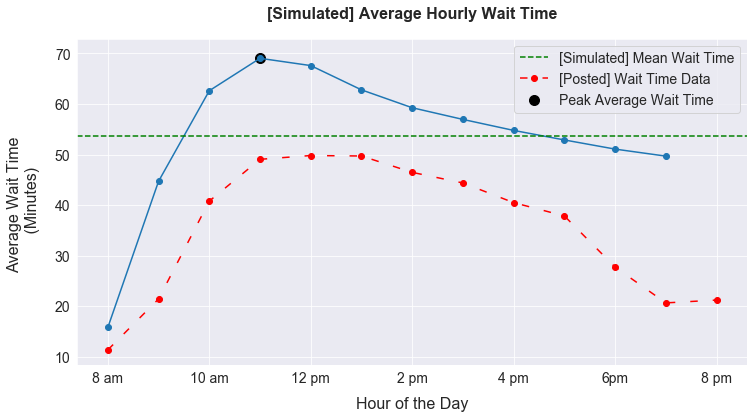

In [22]:
## Plotting Average Wait Time vs Time of Day ## 
testdf = df.groupby('arrival hour')[['wait']].mean()

sns.set_style('darkgrid')
fig1b, ax1b = plt.subplots(figsize = (12, 6))

#sns.lineplot(data = df, x = 'arrival hour', y = 'wait', ci = 'sd')
plt.plot(testdf.index, testdf['wait'], marker = 'o')
ax1b.axhline(y = np.mean(df['wait']), c = 'g',linestyle = 'dashed', label = '[Simulated] Mean Wait Time')
plt.plot(november_grouped.reset_index().index, november_grouped['wait'], 'o',linestyle = (0, (5,10)), c = 'r', label = '[Posted] Wait Time Data')
plt.scatter(df.groupby('arrival hour').mean()['wait'].argmax(), df.groupby('arrival hour').mean()['wait'].max(), marker = 'o' , 
            s = 100, c = 'k', label = 'Peak Average Wait Time')

plt.title('[Simulated] Average Hourly Wait Time', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Hour of the Day', fontsize = 16, labelpad = 10)
plt.ylabel('Average Wait Time \n (Minutes)', fontsize = 16, labelpad = 15)
plt.xticks([0,2,4,6,8,10,12], ['8 am', '10 am', '12 pm', '2 pm', '4 pm', '6pm', '8 pm'], fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(prop={'size': 14})
fig1b.savefig('fig1b.pdf')